This notebook will:
- Extract CSV Data: Obtain a CSV file of the respective holders using M1 Finance's built-in CSV export feature.
- Calculate Metrics: Add Beta and Standard Deviation to the data for the respective time frequencies.
- Export Portfolio Stats: Save the final portfolio statistics to a file upon completion.
- Plot Analysis: Visualize total risk and return over a specified time frame.
- Note: 
    - This notebook assumes you are using macOS 
    - That the file is downloaded to the Desktop, and relfects todays date

Libraries

In [59]:
from datetime import datetime, timedelta, date
import numpy as np
import pandas as pd
import scipy.stats
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

Global Varibales

In [60]:
historical_years = 5
time_freq = '1d'

# Change start date accordingly 
todays_date = date.today()
start_date = datetime.now() - timedelta(days=historical_years*365)

# Put user name here
user = ''
export_path = f'data/portfolio_info_{todays_date}.csv'

# Asjust file path
formatted_date = todays_date.strftime('%b-%d-%Y')
file_path = f'/Users/{user}/Desktop/Holdings-{formatted_date}.csv'

try:
    raw_portfolio_df = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError('Enter User, or select updated CSV file from M1 Finance.')

Functions

In [61]:

def get_stock_data_w_returns(symbol: str, freq: str=time_freq) -> pd.DataFrame:
    # Retrieves stock data for the given ticker and calculates returns

    stock_df = yf.download(symbol, start=start_date, end=todays_date, interval=freq, rounding=True)
    stock_df['Returns (%)'] = (stock_df['Adj Close'].pct_change() * 100).round(2)
    stock_df.reset_index(inplace=True) 
    stock_df.dropna(inplace=True)
    return stock_df

def calculate_average_return(symbol: str) -> float:
    # Calculates the average returns for the specified stock symbol

    stock_df = get_stock_data_w_returns(symbol)
    return stock_df['Returns (%)'].mean()

def get_stock_beta(symbol: str) -> float:
    # Calculates stock beta agains SPY
    
    stock_returns = get_stock_data_w_returns(symbol)['Returns (%)']
    spy_returns = get_stock_data_w_returns('SPY')['Returns (%)']
    cov_matrix = np.cov(stock_returns, spy_returns)
    cov_stock_spy = cov_matrix[0, 1]
    var_spy = np.var(spy_returns)
    beta = cov_stock_spy / var_spy
    return beta.round(2)

def get_stock_std(symbol: str) -> float:
    # Calculates stock Standard Deviation agains SPY

    stock_returns = get_stock_data_w_returns(symbol)['Returns (%)']
    stock_std = np.sqrt(np.var(stock_returns))
    return stock_std

Data Cleaning, and Manipluation

In [62]:
raw_portfolio_df['Average_returns'] = raw_portfolio_df['Symbol'].apply(calculate_average_return)
raw_portfolio_df['Beta'] = raw_portfolio_df['Symbol'].apply(get_stock_beta)
raw_portfolio_df['Standard_dev'] = raw_portfolio_df['Symbol'].apply(get_stock_std)
raw_portfolio_df['Total_risk'] = raw_portfolio_df['Beta'] + raw_portfolio_df['Standard_dev']
portfolio_df = raw_portfolio_df.copy()
portfolio_df.columns = portfolio_df.columns.str.replace(' ', '_')
portfolio_df.columns = portfolio_df.columns.str.capitalize()
risk_return_df = raw_portfolio_df[['Symbol', 'Average_returns',	'Beta',	'Standard_dev',	'Total_risk']]

# portfolio_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

File Export

In [63]:
portfolio_df.to_csv(f'data/portfolio_stats_{formatted_date}.csv')

Plotting

Text(0.05, -0.025, 'Time frame: 5 yr(s)\nInterval: 1d')

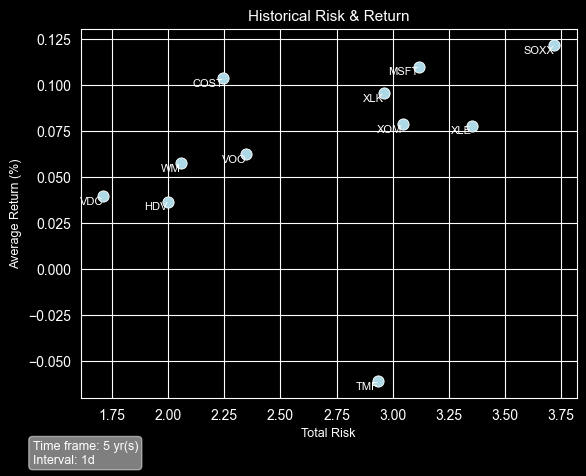

In [64]:
sns.set_style('darkgrid')
plt.style.use('dark_background')

# Create scatter plot
sns.scatterplot(
    data=risk_return_df, x='Total_risk', y='Average_returns', 
    color='lightblue', legend=None, s=65, edgecolor='white',
)

# Annotate the symbols
symbol_positions = {}
for index, row in risk_return_df.iterrows():
    x, y = row['Total_risk'], row['Average_returns']
    symbol = row['Symbol']
    
    if (x, y) in symbol_positions.values():
        for i in range(1, len(symbol) + 1):
            if (x, y - i * 0.05) not in symbol_positions.values():
                y -= i * 0.05
                break
    symbol_positions[symbol] = (x, y)
    plt.text(x, y, symbol, ha='right', va='top', fontsize=8, color='white')

# Add axis labels and title
plt.xlabel('Total Risk', fontsize=9)
plt.ylabel('Average Return (%)', fontsize=9)
plt.title('Historical Risk & Return', fontsize=11)

# Add text box with time frame and period
textstr = f'Time frame: {historical_years} yr(s)\nInterval: {time_freq}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gcf().text(0.05, -0.025, textstr, fontsize=9, bbox=props)